In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import clear_output
import os
import sys
import face_alignment
from skimage import io
from sklearn.metrics.pairwise import euclidean_distances
from scipy.optimize import minimize
import dlib
import alphashape
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from copy import copy

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [ ]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [ ]:
def calc_recall(prediction, ground_truth):
    n_images = len(prediction)
    intersection, tr = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        tr += (ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / tr


In [ ]:
def imshow(img, cmap='gray'):
    plt.figure(dpi = 300)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

# Functions to find forehead points

In [ ]:
def lineFromPoints(point1, point2):
  a = (point1[1]-point2[1])/(point1[0]-point2[0]+1e-4)
  b = point1[1] - a*point1[0]
  d = euclidean_distances(point1.reshape(1,2), point2.reshape(1,2))[0][0]
  return a, b, d

def find_intersection(a1, b1, a2, b2):
    x = (b2-b1)/(a1-a2)
    y = a1*x+b1
    return np.array([x, y]).astype(int)

def func(x, a, b):
  return np.array([x, x*a + b])

def point_along(pointA, pointB, a, b, dist):
    x1 = pointA[0] - dist*(1/(1 + a**2)**0.5)
    x2 = pointA[0] + dist*(1/(1 + a**2)**0.5)
    dist1 = (((func(x1, a, b) - pointB)**2).sum())**0.5
    dist2 = (((func(x2, a, b) - pointB)**2).sum())**0.5
    if dist1 > dist2:
      x = x1
    else:
      x = x2
    return func(x, a, b)

import itertools

def face_orientation(all_a): # all_a = [atop, aleft, aright]
  tan = []
  for a in all_a:
    arctan = np.arctan(a)*180/3.14
    if arctan > 0:
      tan.append(arctan)
    else:
      tan.append(180 + arctan)
  diff = []
  for subset in itertools.combinations(tan, 2):
    diff.append(abs(subset[0] - subset[1]))
  if diff[0] < 5:
    # print(1)
    coef = [1.7, 2, 1.8]
  elif diff[1] < 5:
    # print(2)
    coef = [1.7, 1.8, 2]
  elif diff[2] < 5:
    # print(3)
    coef = [1.4, 1.9, 1.9]
  else:
    # print(4)
    coef = [1.7, 1.5, 1.5]
  return coef

def add_points(points):
  anose, bnose, Dnose = lineFromPoints(points[27].astype(float), points[30].astype(float))
  abrow, bbrow, _ = lineFromPoints(points[21].astype(float), points[22].astype(float))
  base_center = find_intersection(anose, bnose, abrow, bbrow)

  
  atop, btop, _ = lineFromPoints(points[0].astype(float), points[16].astype(float))
  aleft, bleft, _ = lineFromPoints(points[36].astype(float), points[48].astype(float))
  aright, bright, _ = lineFromPoints(points[45].astype(float), points[54].astype(float))
  base_left = find_intersection(aleft, bleft, atop, btop)
  base_right = find_intersection(aright, bright, atop, btop)

  coefs = face_orientation([anose, aleft, aright])
  
  A = point_along(base_center, points[30], anose, bnose, Dnose*coefs[0])
  B = point_along(base_left, points[48], aleft, bleft, Dnose*coefs[1])
  C = point_along(base_right, points[54], aright, bright, Dnose*coefs[2])
  # print(C, A, B)
  return np.array([C, A, B])

# 1. Uploading data

In [ ]:
DATA_DIR = 'dataset'
fname = f'{DATA_DIR}'
!unzip -o {DATA_DIR}

DATA_DIR = 'shape_predictor_68_face_landmarks'
fname = f'{DATA_DIR}'

# 2. Face detection


In [ ]:
#using dlib detectig face and making the bounding box
try:
  image_p = f"dataset/image_1.jpg"
  mask = "dataset/mask1/mask_1.jpg"
  image = cv2.imread(image_p)
  image.shape[0]
except (AttributeError) as e:
  imaeg_path = f"dataset/images/image_1.png"
  mask_path = f"dataset/masks/mask_1.png"
  image = cv2.imread(image_p)

if image.shape[0] > 2500:
  (h, w) = image.shape[:2]
  image = cv2.resize(image, (int(w * 2500 / float(h)), 2500))
imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
imageGRAY = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

ground_truth = cv2.imread(mask_path)
ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)
ground_truth = np.uint8((ground_truth > 240)*255)

## 2.1. DLIB Library

In [ ]:
#using this we are detecting the faces
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

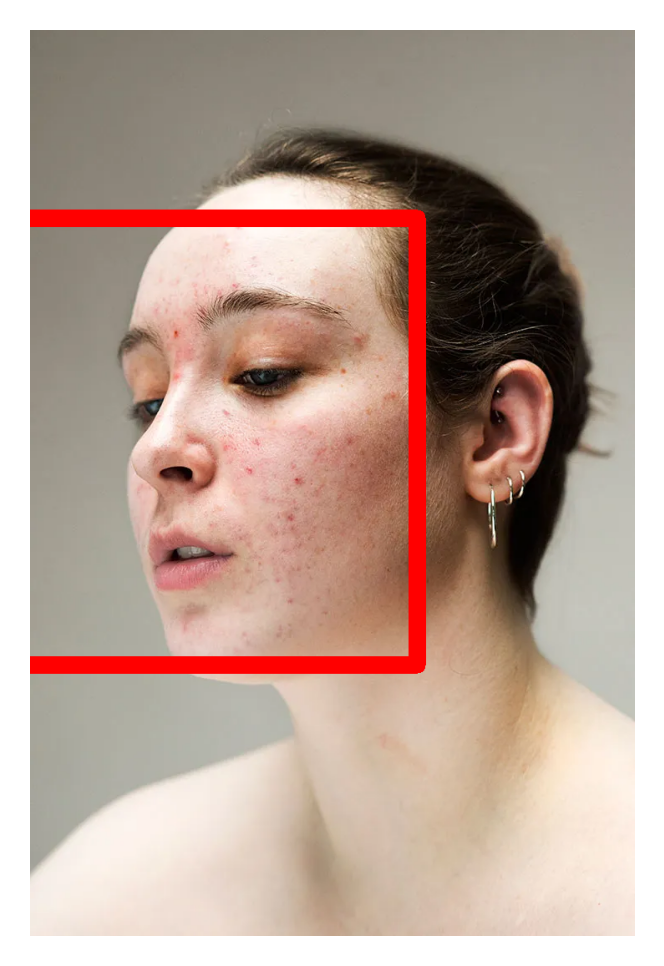

In [ ]:
#here we make a bounding box around the detected face
faces = detector(imageGRAY)
img = imageRGB.copy()
for face in faces:
    x = face.left()
    y = face.top()
    w = face.right() - x
    h = face.bottom() - y
    img = cv2.rectangle(img, (x, y), (x + w,y + h), (255, 0, 0), 20)
imshow(img)

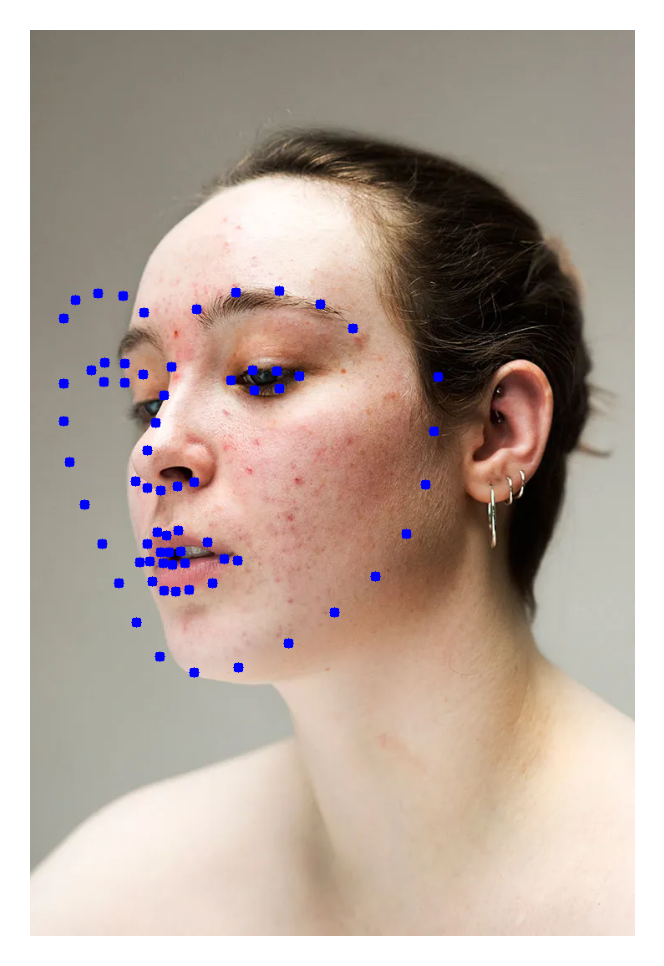

In [ ]:
#here we make the patches around the detected face on the areas we want to omit
for face in faces:
  shape = predictor(imageGRAY, face)

image_draw = imageRGB.copy()
coords = np.zeros((68, 2))
for i in range(0, 68):
  coords[i] = (shape.part(i).x, shape.part(i).y)
for points in coords:
  cv2.circle(image_draw, (points[0].astype(int), points[1].astype(int)), 1, (0, 0, 255), 10)
imshow(image_draw)

## 2.2 Face Alignment Network (FAN)

(-0.5, 723.5, 1084.5, -0.5)

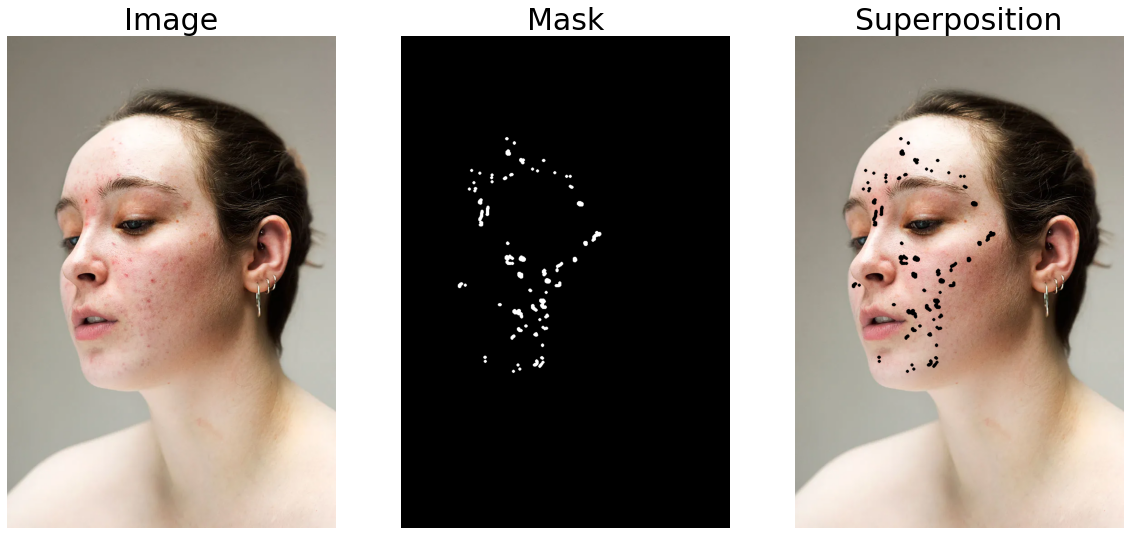

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

ax[0].imshow(imageRGB)
ax[0].set_title('Image', fontsize=30)
ax[0].axis('off')

ax[1].imshow(ground_truth, cmap='gray')
ax[1].set_title('Mask', fontsize=30)
ax[1].axis('off')

superpos = imageRGB.copy()
superpos[ground_truth == 255] = 0
ax[2].imshow(superpos, cmap='gray')
ax[2].set_title('Superposition', fontsize=30)
ax[2].axis('off')

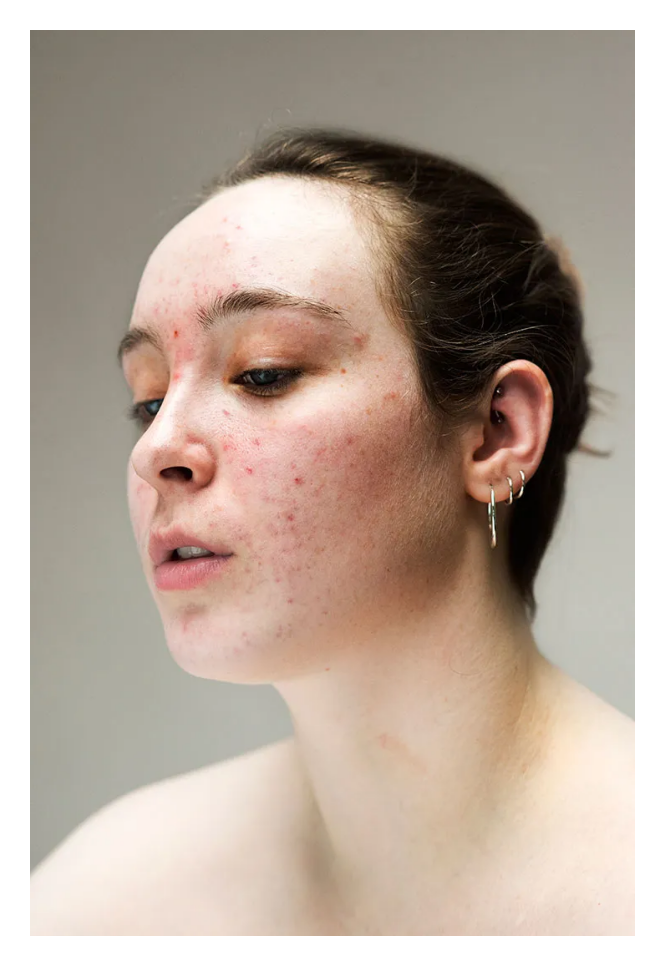

In [ ]:
imshow(imageRGB)

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-11f355bf06.pth.tar" to /root/.cache/torch/hub/checkpoints/2DFAN4-11f355bf06.pth.tar


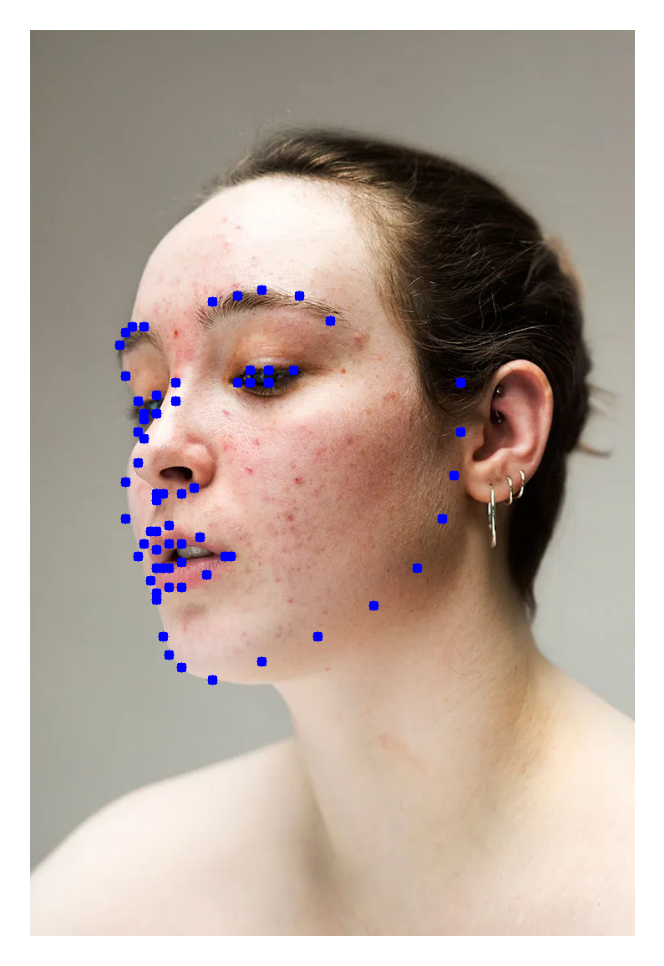

In [ ]:
#here we predict the points where patches present
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)
preds = fa.get_landmarks_from_image(imageRGB)

image_draw = copy(imageRGB)
for points in preds[0]:
  cv2.circle(image_draw, (points[0].astype(int), points[1].astype(int)), 1, (0, 0, 255), 10)
imshow(image_draw) 

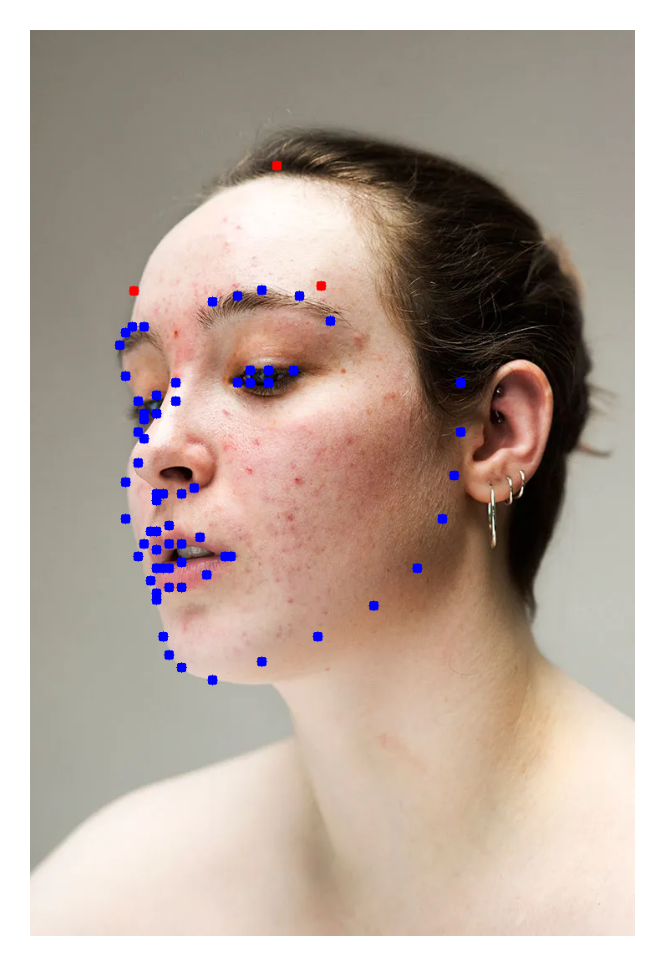

In [ ]:
image_draw = copy(imageRGB)

for points in preds[0]:
  cv2.circle(image_draw, (points[0].astype(int), points[1].astype(int)), 1, (0, 0, 255), 10)

# Additional points for forehead
for points in add_points(preds[0]):
  cv2.circle(image_draw, (points[0].astype(int), points[1].astype(int)), 1, (255, 0, 0), 10)


imshow(image_draw)

In [ ]:
points = np.vstack((preds[0], add_points(preds[0])))

alpha = 0.8 * alphashape.optimizealpha(points, max_iterations = 20000)
hull = alphashape.alphashape(points, alpha)
hull_pts_x, hull_pts_y  = hull.exterior.coords.xy

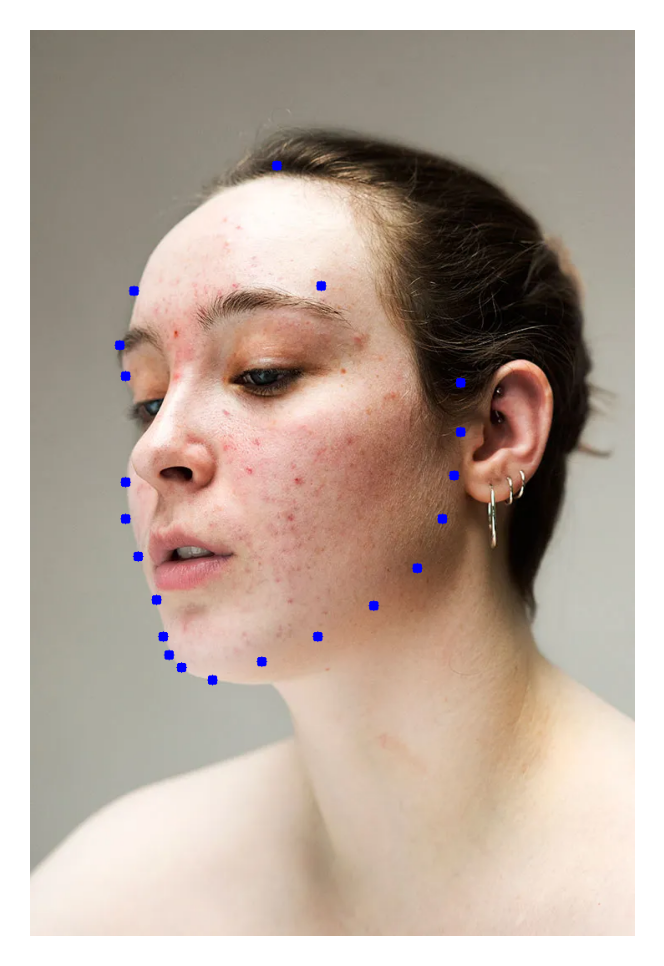

In [ ]:
image_draw = copy(imageRGB)

for i in range(len(hull_pts_y)):
  cv2.circle(image_draw, (np.array(hull_pts_x[i]).astype(int), np.array(hull_pts_y[i]).astype(int)), 1, (0, 0, 255), 10)

imshow(image_draw)

# 3. Acne detection

## 3.1. Thresholding based on skin colour

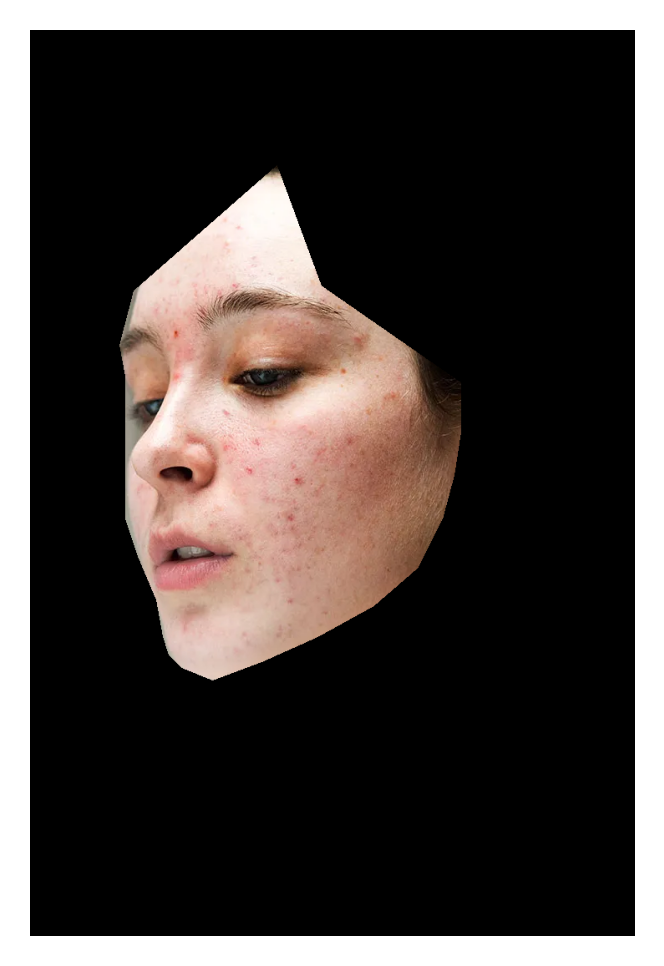

In [ ]:
#in this part we are detecting the acne based on the changes in skin colour as acne/pimple colour is different from skin colour generally
image_count = np.zeros(imageRGB.shape[:-1])
image_draw = copy(imageRGB)

face = np.vstack([np.array(hull_pts_x), np.array(hull_pts_y)]).T
cv2.fillPoly(image_count, pts = [face.astype(int)], color=(1))
image_draw[image_count == 0] = 0

plt.figure(dpi = 300)
plt.imshow(image_draw)    
plt.axis('off')


kernel = np.ones((5,5),np.uint8)
eros = cv2.erode(image_count , kernel,iterations = 5)

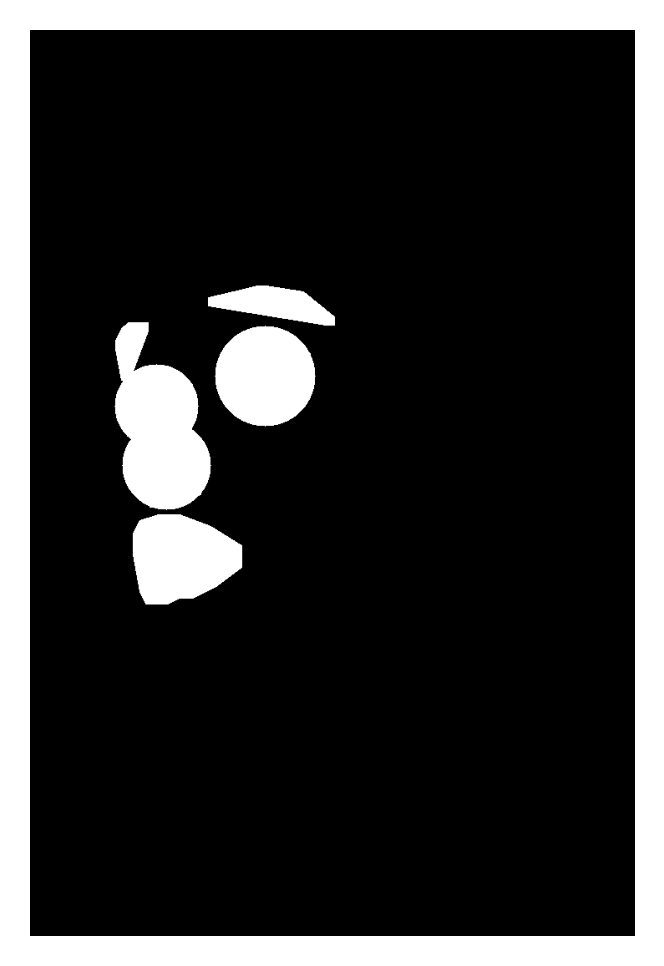

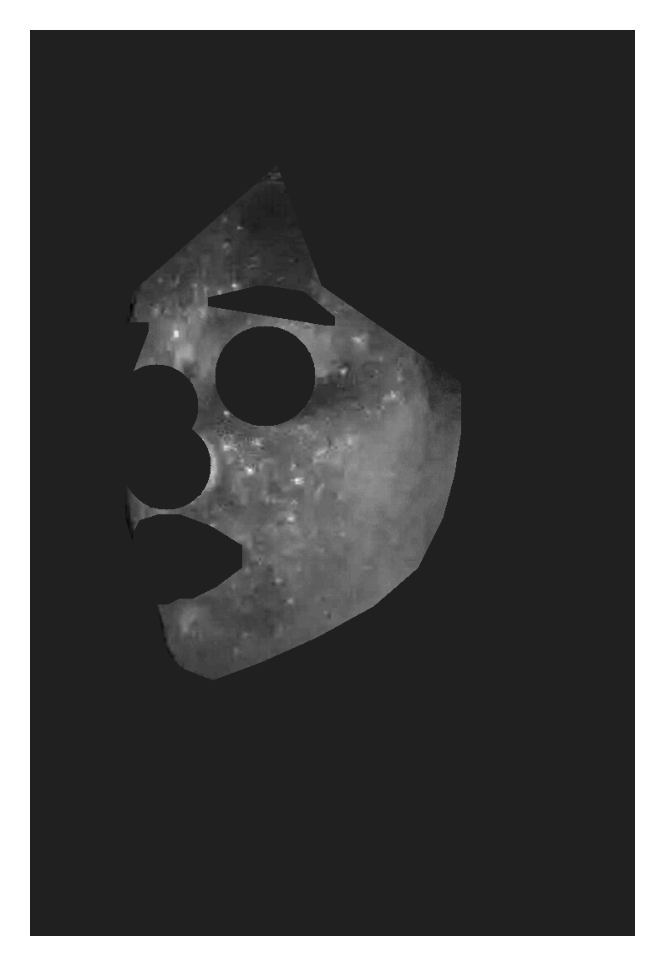

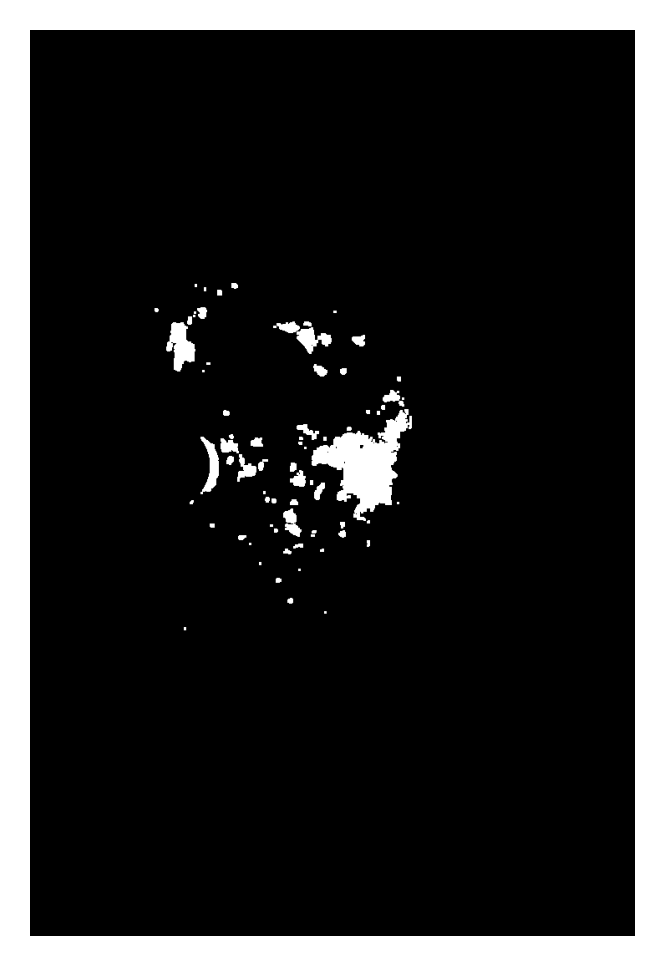

In [ ]:
image_cnt_1 = np.zeros(imageRGB.shape[:-1])
#here we are omiting the points or patches we detected before as there are less changes of pimples of present at those patches
left_eyebrow = points[17:22]
right_eyebrow = points[22:27]
left_eye = points[36:42]
right_eye = points[42:48]
mouth = points[48:60]
nose = points[29:36]

nose_n = cv2.convexHull(nose.astype(int))[:, 0, :]

alpha = 0.95 * alphashape.optimizealpha(mouth)
hull_m = alphashape.alphashape(mouth, alpha)
hull_pts_x_m, hull_pts_y_m  = hull_m.exterior.coords.xy
mouth_m = np.vstack([np.array(hull_pts_x_m), np.array(hull_pts_y_m)]).T

if points[16][0] < points[33][0]:
  face_parts = [left_eyebrow, left_eye, nose_n, mouth_m]
  iterations = [5, 20, 8, 13]
  labels = ['eyebrow', 'eye', 'nose', 'mouth']
elif points[1][0] > points[33][0]:
  face_parts = [right_eyebrow, right_eye, nose_n, mouth_m]
  iterations = [5, 20, 8, 13]
  labels = ['eyebrow', 'eye', 'nose', 'mouth']
else:
  face_parts = [left_eyebrow, left_eye, right_eyebrow, right_eye, nose_n, mouth_m]
  iterations = [5, 20, 5, 20, 8, 13]
  labels = ['eyebrow', 'eye', 'eyebrow', 'eye', 'nose', 'mouth']

for (part, iter, label) in zip(face_parts, iterations, labels):
  img_iter = np.zeros(imageRGB.shape[:-1])
  cv2.fillPoly(img_iter, pts = [part.astype(int)], color=(1))
  img_iter = cv2.dilate(img_iter, kernel=np.ones((3, 3)), iterations=iter)
  if (label == 'eye') | (label == 'nose'):
    contours, hierarchy = cv2.findContours(img_iter.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    (x,y),radius = cv2.minEnclosingCircle(contours[0])
    center = (int(x),int(y))
    if (label == 'nose'):
      radius = int(radius*1)
    if (label == 'eye'):
      radius = int(radius*1)
    cv2.circle(img_iter, center, radius, (1), -1)
  image_cnt_1 += img_iter
image_cnt_1 = (image_cnt_1>0)*1
imshow(image_cnt_1)

acne_mask = image_draw.copy()
img_lab = cv2.cvtColor(acne_mask, cv2.COLOR_RGB2LAB)

A = img_lab[:, :, 1]
A[image_cnt_1 > 0] = 128

imshow(A)

th = np.sum(A*(A > 128))/(np.sum(1*(A > 128)))
A_th = (A>th*1.055).astype(np.uint8)
kernel = np.ones((3,3))
A_th = cv2.morphologyEx(A_th, cv2.MORPH_CLOSE, kernel, iterations = 1)
A_th = cv2.dilate(np.uint8(A_th), kernel=np.ones((3, 3)), iterations = 1)

imshow(A_th)

A_th[image_cnt_1 > 0] = 0
img_bin = A_th.copy()

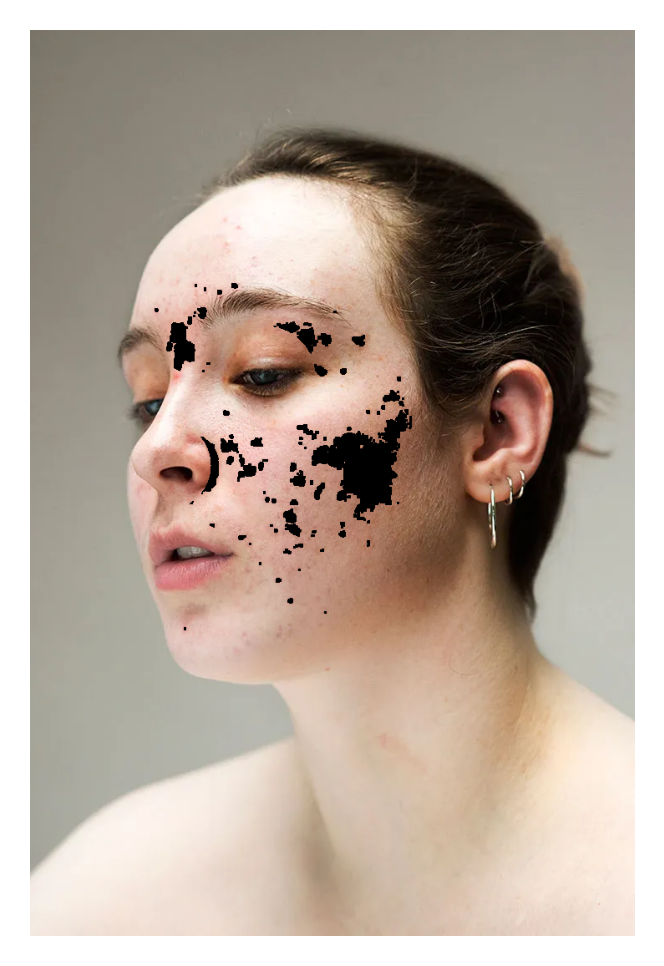

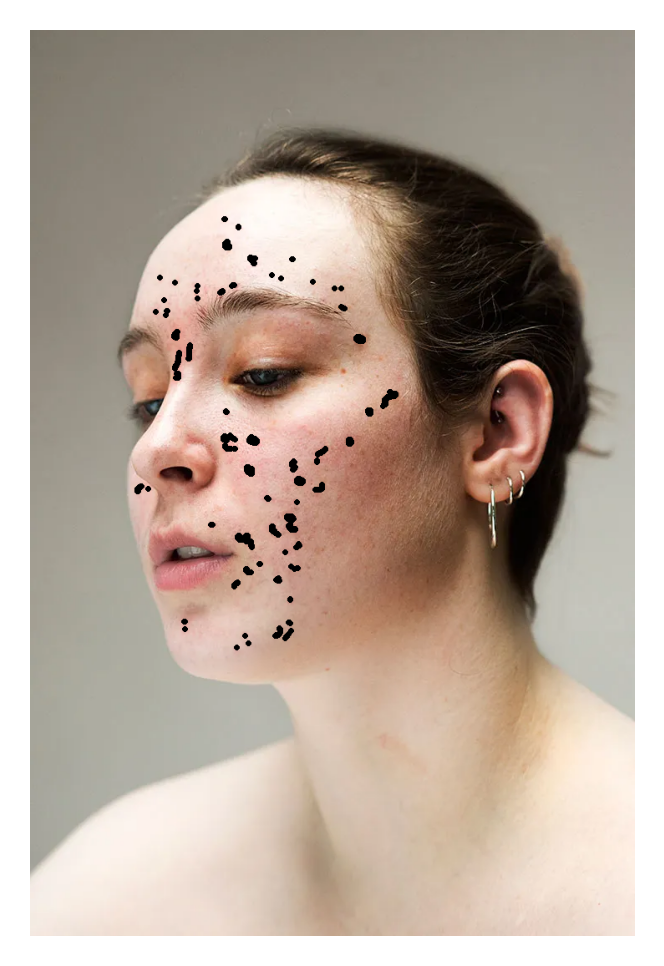

In [ ]:
#here the image we are getting is after omitting those part where location of pimples is very less 
final_img = imageRGB.copy()
final_img[img_bin == 1] = 0
acne_mask = np.ones(img_bin.shape)
acne_mask[img_bin == 1] = 0

imshow(final_img)

prediction = acne_mask.astype(np.uint8)-1

final_img_masked = imageRGB.copy()
final_img_masked[ground_truth == 255] = 0
imshow(final_img_masked)

In [ ]:
print(calc_iou([prediction], [ground_truth]))
print(calc_recall([prediction], [ground_truth]))

0.147426316733425
0.4417771408097456


#4. Estimate all (function to process image + metric calculation)

In [ ]:
def find_mask(idx, mode, show = True):
  try:
    img_path = f"final_dataset/images/t{idx}.jpg"
    mask_path = f"final_dataset/masks/t{idx}_mask.jpg"
    image = cv2.imread(img_path)
    image.shape[0]
  except (AttributeError) as e:
    img_path = f"final_dataset/images/t{idx}.png"
    mask_path = f"final_dataset/masks/t{idx}_mask.png"
    image = cv2.imread(img_path)

  if image.shape[0] > 2500:
    (h, w) = image.shape[:2]
    image = cv2.resize(image, (int(w * 2500 / float(h)), 2500))
  imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  ground_truth = cv2.imread(mask_path)
  ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)
  ground_truth = np.uint8((ground_truth > 240)*255)

  fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)
  preds = fa.get_landmarks_from_image(imageRGB)

  points_71 = np.vstack((preds[0], add_points(preds[0])))

  alpha = 0.8 * alphashape.optimizealpha(points_71, max_iterations = 20000)
  hull = alphashape.alphashape(points_71, alpha)
  hull_pts_x, hull_pts_y  = hull.exterior.coords.xy
  
  img_cnt = np.zeros(imageRGB.shape[:-1])
  image_draw = copy(imageRGB)

  face = np.vstack([np.array(hull_pts_x), np.array(hull_pts_y)]).T
  cv2.fillPoly(img_cnt, pts = [face.astype(int)], color=(1))
  image_draw[img_cnt == 0] = 0

  kernel = np.ones((5,5),np.uint8)
  eros = cv2.erode(img_cnt, kernel,iterations = 5)

  img_cnt_1 = np.zeros(imageRGB.shape[:-1])
  left_eyebrow = points_71[17:22]
  right_eyebrow = points_71[22:27]
  left_eye = points_71[36:42]
  right_eye = points_71[42:48]
  mouth = points_71[48:60]
  nose = points_71[29:36]

  nose_n = cv2.convexHull(nose.astype(int))[:, 0, :]

  alpha = 0.95 * alphashape.optimizealpha(mouth)
  hull_m = alphashape.alphashape(mouth, alpha)
  hull_pts_x_m, hull_pts_y_m  = hull_m.exterior.coords.xy
  mouth_m = np.vstack([np.array(hull_pts_x_m), np.array(hull_pts_y_m)]).T


  if points_71[16][0] < points_71[33][0]:
    face_parts = [left_eyebrow, left_eye, nose_n, mouth_m]
    iterations = [5, 20, 8, 11]
    labels = ['eyebrow', 'eye', 'nose', 'mouth']
  elif points_71[1][0] > points_71[33][0]:
    face_parts = [right_eyebrow, right_eye, nose_n, mouth_m]
    iterations = [5, 20, 8, 11]
    labels = ['eyebrow', 'eye', 'nose', 'mouth']
  else:
    face_parts = [left_eyebrow, left_eye, right_eyebrow, right_eye, nose_n, mouth_m]
    iterations = [5, 20, 5, 20, 8, 11]
    labels = ['eyebrow', 'eye', 'eyebrow', 'eye', 'nose', 'mouth']

  for (part, iter, label) in zip(face_parts, iterations, labels):
    img_iter = np.zeros(imageRGB.shape[:-1])
    cv2.fillPoly(img_iter, pts = [part.astype(int)], color=(1))
    img_iter = cv2.dilate(img_iter, kernel=np.ones((3, 3)), iterations=iter)
    if (label == 'eye') | (label == 'nose'):
      contours, hierarchy = cv2.findContours(img_iter.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      (x,y),radius = cv2.minEnclosingCircle(contours[0])
      center = (int(x),int(y))
      if (label == 'nose'):
        radius = int(radius*1.1)
      if (label == 'eye'):
        radius = int(radius*1.05)
      cv2.circle(img_iter, center, radius, (1), -1)
    img_cnt_1 += img_iter
  img_cnt_1 = (img_cnt_1>0)*1
  
  img_lab = cv2.cvtColor(imageRGB.copy(), cv2.COLOR_RGB2LAB)

  A = img_lab[:, :, 1]
  
  if mode == '1st':
    A[img_cnt_1 > 0] = 128
    A[img_cnt == 0] = 128
    th = np.sum(A*(A > 128))/(np.sum(1*(A > 128)))
    A_th = (A>th*1.05).astype(np.uint8)
    kernel = np.ones((3,3))
    A_th = cv2.morphologyEx(A_th, cv2.MORPH_CLOSE, kernel, iterations = 1)
    A_th = cv2.dilate(np.uint8(A_th), kernel=np.ones((3, 3)), iterations = 1)
    A_th[img_cnt_1 > 0] = 0
    img_bin = A_th.copy()

    final_img = imageRGB.copy()
    final_img[img_bin == 1] = 0
    acne_mask = np.ones(img_bin.shape)
    acne_mask[img_bin == 1] = 0
    prediction = acne_mask.astype(np.uint8)-1

  if mode == '2nd':
    kernel = np.ones((19,19), np.float32)/500
    GB = cv2.filter2D(A ,-1, kernel)
    diff = A-GB
    diff[(img_cnt_1 - 1)*(-1)*img_cnt == 0] = 0
    
    img_bin = (diff>42)*1
    img_bin[eros == 0] = 0

    final_img = imageRGB.copy()
    img_bin = cv2.dilate(np.uint8(img_bin), kernel=np.ones((3, 3)), iterations = 1)
    final_img[img_bin == 1] = 0
    acne_mask = np.ones(img_bin.shape)
    acne_mask[img_bin == 1] = 0
    prediction = acne_mask.astype(np.uint8)-1


  score = calc_recall([prediction], [ground_truth])
  if show:
    print(score)
    
    fig, ax = plt.subplots(3, 1, figsize=(10, 20))

    ax[0].imshow(imageRGB)
    ax[0].set_title('Image')
    ax[0].axis('off')

    superpos_pr = imageRGB.copy()
    superpos_pr[prediction == 255] = 0
    ax[1].imshow(superpos_pr)
    ax[1].set_title('Superposotion_prediction')
    ax[1].axis('off')

    superpos_tr = imageRGB.copy()
    superpos_tr[ground_truth == 255] = 0
    ax[2].imshow(superpos_tr)
    ax[2].set_title('Superposotion_truth')
    ax[2].axis('off')

  return final_img, prediction, acne_mask, score

0.5942314582586886


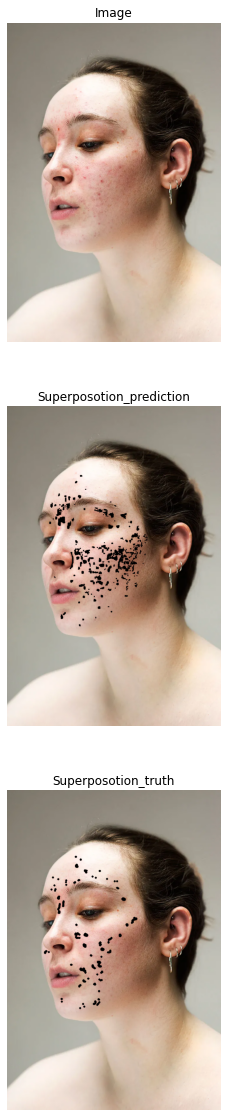

In [ ]:
final_img, prediction, acne_mask, score = find_mask(idx = 18, mode = '2nd', show = True)

In [ ]:
scores_1 = []
scores_2 = []
for idx in range(1,31):
  final_img, prediction, acne_mask, score = find_mask(idx = idx, mode = '1st', show = False)
  scores_1.append(score)
  final_img, prediction, acne_mask, score = find_mask(idx = idx, mode = '2nd', show = False)
  scores_2.append(score)
  print(idx, '\t', round(scores_1[idx-1], 3), '\t', round(scores_2[idx-1], 3))

1 	 0.72 	 0.613
2 	 0.548 	 0.6
3 	 0.458 	 0.531
4 	 0.634 	 0.772
5 	 0.13 	 0.142
6 	 0.353 	 0.597
7 	 0.075 	 0.07
8 	 0.354 	 0.791
9 	 0.27 	 0.667
10 	 0.693 	 0.465
11 	 0.771 	 0.681
12 	 0.373 	 0.314
13 	 0.685 	 0.567
14 	 0.611 	 0.715
15 	 0.553 	 0.544
16 	 0.39 	 0.448
17 	 0.333 	 0.539
18 	 0.439 	 0.594
19 	 0.53 	 0.602
20 	 0.239 	 0.299
21 	 0.358 	 0.3
22 	 0.479 	 0.581
23 	 0.517 	 0.493
24 	 0.097 	 0.052
25 	 0.084 	 0.109
26 	 0.143 	 0.317
27 	 0.332 	 0.492
28 	 0.668 	 0.798
29 	 0.371 	 0.372
30 	 0.33 	 0.507


In [ ]:
scores_1 = np.array(scores_1)
scores_2 = np.array(scores_2)

print(np.mean(scores_1))
print(np.mean(scores_2))

0.4178603373029306
0.48577702364278674


# 5. Inpainting

In [ ]:
#removing those detected pimple 

try:
  image_path = f"dataset/images/image_1.jpg"
  image = cv2.imread(image_path)
  image.shape[0]
except (AttributeError) as e:
  image_path = f"dataset/images/image_1.png"
  image = cv2.imread(image_path)

imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

0.5942314582586886


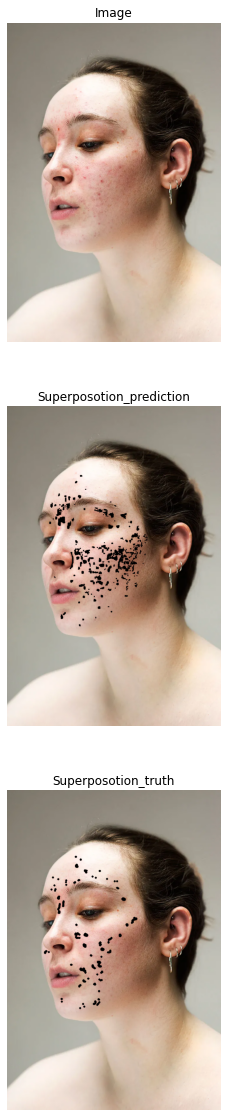

In [ ]:
final_img, prediction, acne_mask, score = find_mask(idx = 1 , mode = '2nd', show = True)

## 5.1. Deep Learning Model

In [ ]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, p):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.InstanceNorm2d(out_channels)
        self.drop = nn.Dropout(p)
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.InstanceNorm2d(out_channels)
        self.relu2 = nn.LeakyReLU()

        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.drop(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out_before_pooling = self.relu2(out)
        out = self.maxpool(out_before_pooling)

        return out, out_before_pooling

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, p, concat=True, deconv=False, mode='nearest'):
        super().__init__()

        if deconv:
            self.upsample = nn.ConvTranspose2d(in_channels, in_channels, 4, stride=2, padding=1)
        else:
            self.upsample = nn.Upsample(scale_factor=2, mode=mode)
        if concat:
            self.conv1 = nn.Conv2d(2*in_channels, out_channels, kernel_size=3, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.InstanceNorm2d(out_channels)
        self.drop = nn.Dropout(p)
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.InstanceNorm2d(out_channels)
        self.relu2 = nn.LeakyReLU()
        self.concat = concat
        
    def forward(self, x, x_bridge):

        out = self.upsample(x)
        if self.concat:
            out = torch.cat([out, x_bridge], dim=1)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.drop(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        return out

class Unet(nn.Module):
  def __init__(self, p, base_channels=16, concat=True, deconv=False, mode='nearest'):
        super().__init__()
  
        self.down = nn.ModuleList([
            Down(3, base_channels, p),                 
            Down(base_channels, base_channels * 2, p),
            Down(base_channels * 2, base_channels * 4, p),
            Down(base_channels * 4, base_channels * 8, p),
            Down(base_channels * 8, base_channels * 8, p),
        ])
        self.up = nn.ModuleList([
            Up(base_channels * 8, base_channels * 4, p, concat, deconv, mode),
            Up(base_channels * 4, base_channels * 2, p, concat, deconv, mode),
            Up(base_channels * 2, base_channels, p, concat, deconv, mode),
            Up(base_channels, base_channels, p, concat, deconv, mode)
        ])
        self.final_block = nn.Sequential(
            nn.Conv2d(base_channels, 3, kernel_size=1),
            nn.Sigmoid()
        )
            
        
  def forward(self, x):
      out = x
      outputs_before_pooling = []
      for i, block in enumerate(self.down):
          out, before_pooling = block(out)
          outputs_before_pooling.append(before_pooling)
      out = before_pooling
      
      for i, block in enumerate(self.up):  
          out = block(out, outputs_before_pooling[-i - 2])
      out = self.final_block(out)
      
      return out

In [ ]:
#defining function for cropping the image
def crop_image(img, d=64):
    hor = img.shape[0] % d
    ver = img.shape[1] % d
    img_cropped = img[hor//2: img.shape[0] - (hor - hor//2), ver//2:img.shape[1]-(ver - ver//2)]
    return img_cropped


In [ ]:

acne = torch.from_numpy(crop_image(crop_image(final_img/255).astype(float), 16).transpose(2,0,1))
acne_mask = torch.from_numpy(crop_image(acne_mask).astype(float)).unsqueeze(0)

gen_acne = torch.Generator()
gen_acne.manual_seed(305)
z_acne = torch.FloatTensor(acne.shape).uniform_(0, 1, generator=gen_acne)

In [ ]:
model_omg = Unet(p=0.05).cuda()
criterion = nn.MSELoss()
optimizer_acne = torch.optim.Adam(model_omg.parameters(), lr=0.01)

In [ ]:
def train(epochs, model, image_train, mask, z, optimizer, iter):
    images = []
    for epoch in range(1, epochs + 1):
        model.train()
        image_train = image_train.cuda()
        mask = mask.cuda()
        out_image = model(z[None, ...].cuda())
        loss = criterion(out_image*mask[None, ...], image_train[None, ...])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch%iter == 0 or epoch == 1:
            model.eval()
            predict = model(z[None, ...].cuda())
            images.append(predict.detach().cpu().reshape(image_train.shape))


    return predict, images

In [ ]:
acne_impainting, acne_images = train(5000, model_omg, image, acne_mask, z_acne, optimizer_acne, 500)

True

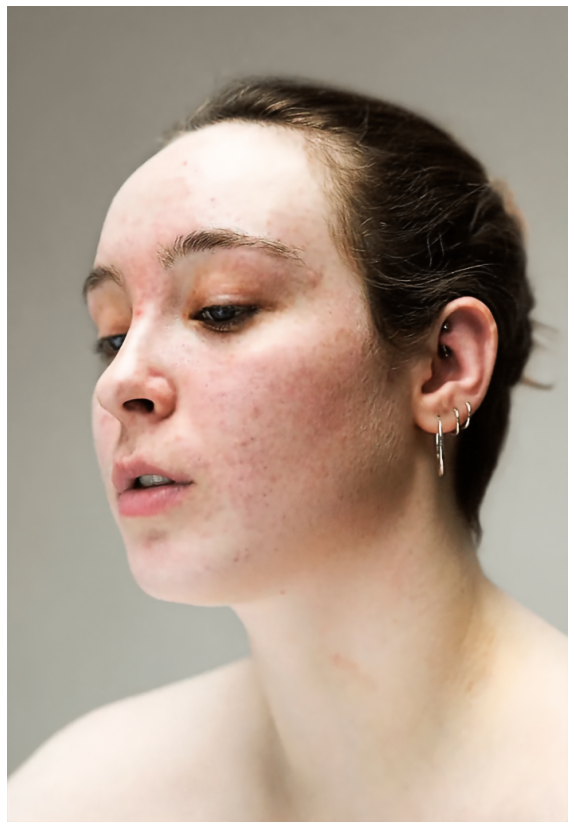

In [ ]:
imshow([acne_images[-1].detach().cpu().reshape(acne.shape)])
img_for_save = np.transpose(acne_images[-1].detach().cpu().reshape(acne.shape).numpy(), (1, 2, 0))*255
cv2.imwrite('prior.jpg', np.uint8(cv2.cvtColor(img_for_save, cv2.COLOR_RGB2BGR))) 

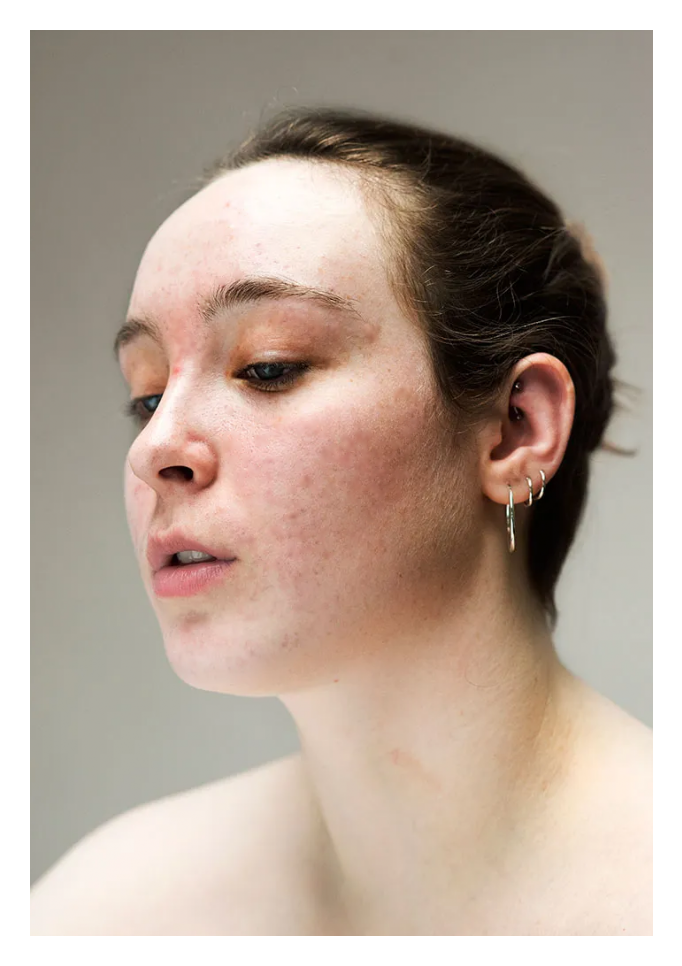

In [ ]:
final_img = crop_image(final_img/255) + img_for_save/255*crop_image((acne_mask==0)*1)[:, :, np.newaxis]
cv2.imwrite('final_prior.jpg', np.uint8(cv2.cvtColor(np.uint8(final_img*255), cv2.COLOR_RGB2BGR))) 
cv2.imwrite('final_original.jpg', np.uint8(cv2.cvtColor(crop_image(imageRGB), cv2.COLOR_RGB2BGR)))
imshow(final_img)